# ==================================================
#    Fraud Detection Full Pipeline
# ==================================================

In [17]:
# -----------------------
# Imports & Environment
# -----------------------
import os
import time
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import (
    confusion_matrix, accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, roc_curve, precision_recall_curve,
    auc, matthews_corrcoef, classification_report
)
from sklearn.metrics import ConfusionMatrixDisplay

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

from imblearn.over_sampling import SMOTE
import joblib

In [19]:
# -----------------------
# Load dataset
# -----------------------
# File path
CSV_PATH = r"C:\Users\Amar Nath\Downloads\Accredian\Fraud.csv"

df = pd.read_csv(CSV_PATH)
print("Loaded shape:", df.shape)
display(df.head())
display(df.tail())

Loaded shape: (6362620, 11)


,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
6362615,743,CASH_OUT,339682.13,C786484425,339682.13,0.0,C776919290,0.00,339682.13,1,0
6362616,743,TRANSFER,6311409.28,C1529008245,6311409.28,0.0,C1881841831,0.00,0.00,1,0
6362617,743,CASH_OUT,6311409.28,C1162922333,6311409.28,0.0,C1365125890,68488.84,6379898.11,1,0
6362618,743,TRANSFER,850002.52,C1685995037,850002.52,0.0,C2080388513,0.00,0.00,1,0
6362619,743,CASH_OUT,850002.52,C1280323807,850002.52,0.0,C873221189,6510099.11,7360101.63,1,0


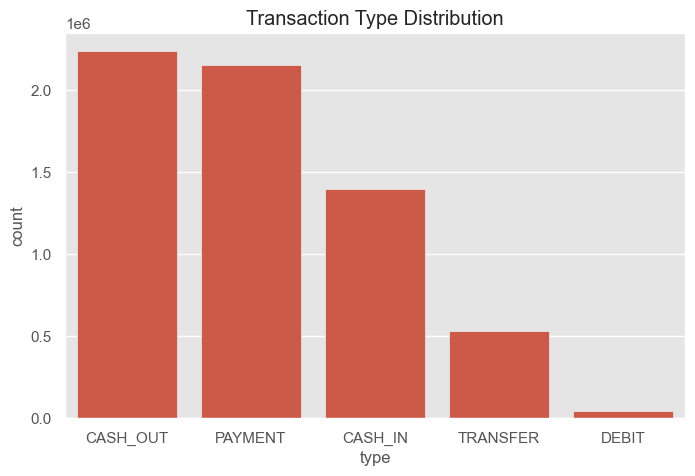

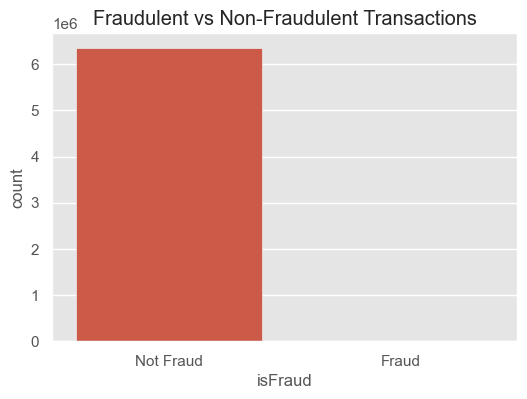

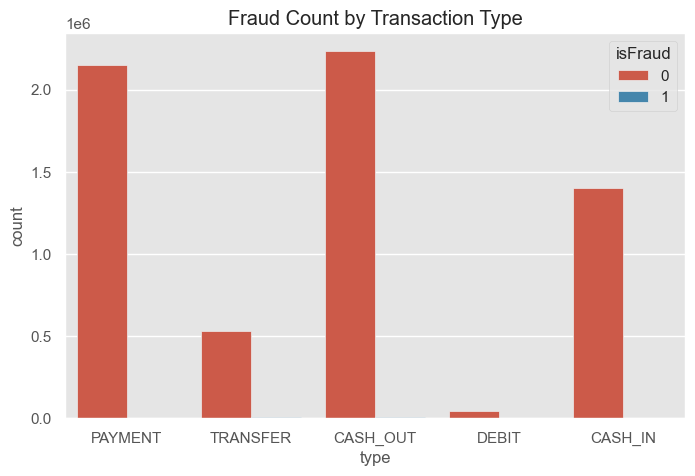

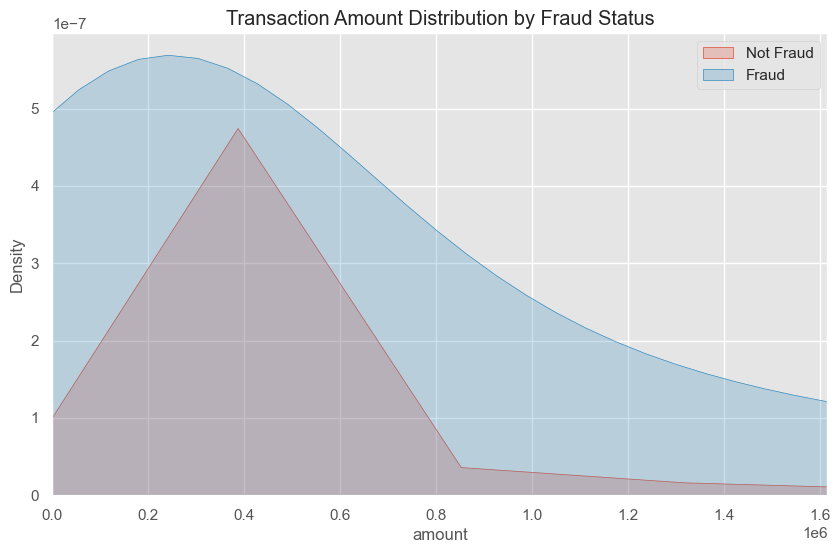

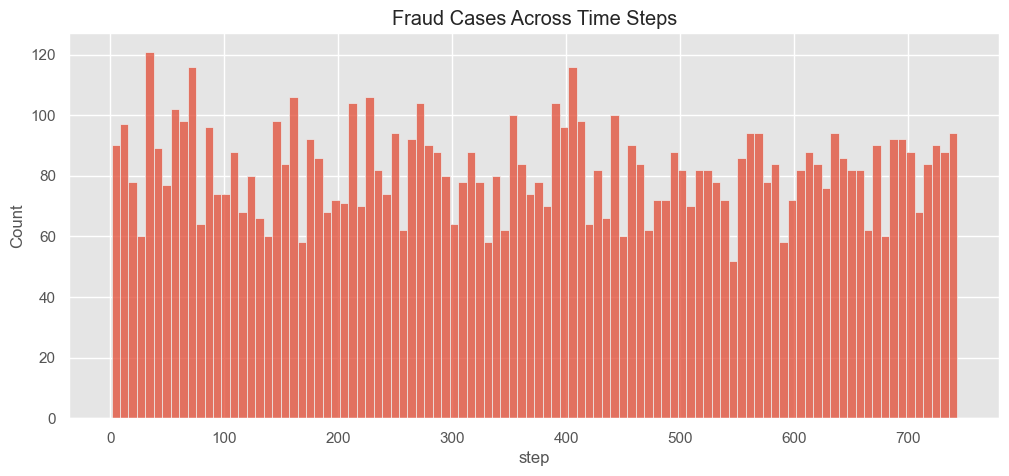

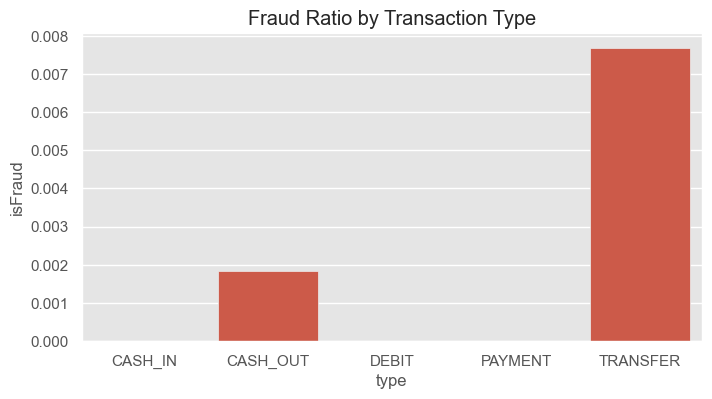

In [21]:
# -----------------------
# EDA & Visualization
# -----------------------

sns.set(style="whitegrid")
plt.style.use('ggplot')

plt.figure(figsize=(8,5))
sns.countplot(data=df, x='type', order=df['type'].value_counts().index)
plt.title("Transaction Type Distribution")
plt.show()

plt.figure(figsize=(6,4))
sns.countplot(x='isFraud', data=df)
plt.title('Fraudulent vs Non-Fraudulent Transactions')
plt.xticks([0,1], ['Not Fraud', 'Fraud'])
plt.show()

plt.figure(figsize=(8,5))
sns.countplot(x='type', hue='isFraud', data=df)
plt.title('Fraud Count by Transaction Type')
plt.show()

plt.figure(figsize=(10,6))
sns.kdeplot(data=df[df['isFraud'] == 0]['amount'], label='Not Fraud', fill=True)
sns.kdeplot(data=df[df['isFraud'] == 1]['amount'], label='Fraud', fill=True)
plt.xlim(0, df['amount'].quantile(0.99))
plt.title('Transaction Amount Distribution by Fraud Status')
plt.legend()
plt.show()

plt.figure(figsize=(12,5))
sns.histplot(df[df['isFraud']==1]['step'], bins=100)
plt.title('Fraud Cases Across Time Steps')
plt.show()

# derived features
df['origin_diff'] = df['oldbalanceOrg'] - df['newbalanceOrig']
df['dest_diff'] = df['newbalanceDest'] - df['oldbalanceDest']

# Fraud ratio by type
fraud_ratio = df.groupby('type')['isFraud'].mean().reset_index()
plt.figure(figsize=(8,4))
sns.barplot(x='type', y='isFraud', data=fraud_ratio)
plt.title('Fraud Ratio by Transaction Type')
plt.show()


In [23]:
# -----------------------
# Preprocessing 
# -----------------------
def preprocess(df_in):
    df_proc = df_in.copy()
    df_proc = df_proc.drop(['nameOrig','nameDest'], axis=1)

    le = LabelEncoder()
    df_proc['type'] = le.fit_transform(df_proc['type'])

    # Scale numeric
    num_cols = df_proc.select_dtypes(include=['float64','int64']).columns.tolist()
    num_cols.remove('isFraud')
    scaler = StandardScaler()
    df_proc[num_cols] = scaler.fit_transform(df_proc[num_cols])
    return df_proc


In [33]:

# -----------------------
# Subsample 20% for model exploration
# -----------------------
df_small = df.sample(frac=0.2, random_state=42).reset_index(drop=True)
df_small = preprocess(df_small)

X_small = df_small.drop('isFraud', axis=1)
y_small = df_small['isFraud']

X_train, X_test, y_train, y_test = train_test_split(
    X_small, y_small, test_size=0.3, random_state=42, stratify=y_small
)
# SMOTE on training data
smote = SMOTE(random_state=42)
X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train)
print("Subsample + SMOTE:", X_train_sm.shape, "Fraud ratio:", y_train_sm.mean())

Subsample + SMOTE: (1779264, 10) Fraud ratio: 0.5


In [35]:

# -----------------------
# Models to compare 
# -----------------------
models = [
    (LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42), "Logistic Regression"),
    (DecisionTreeClassifier(class_weight='balanced', random_state=42), "Decision Tree"),
    (RandomForestClassifier(n_estimators=200, n_jobs=-1, class_weight='balanced', random_state=42), "Random Forest"),
    (GaussianNB(), "Naive Bayes"),
    (XGBClassifier(use_label_encoder=False, eval_metric='logloss', n_estimators=200, max_depth=6,
                   learning_rate=0.1, subsample=0.8, colsample_bytree=0.8, random_state=42, n_jobs=-1), "XGBoost"),
    (LGBMClassifier(n_estimators=200, max_depth=6, learning_rate=0.1, random_state=42, n_jobs=-1), "LightGBM"),
    (CatBoostClassifier(iterations=200, depth=6, learning_rate=0.1, verbose=0, random_state=42), "CatBoost")
]


In [40]:

# -----------------------
# Evaluation function
# -----------------------
results = []

def evaluate_model(model, name):
    print("\n" + "="*70)
    print(f"Model: {name}")
    start = time.time()
    model.fit(X_train_sm, y_train_sm)
    train_time = time.time() - start

    y_pred = model.predict(X_test)
    try:
        y_score = model.predict_proba(X_test)[:,1]
    except:
        y_score = None

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, zero_division=0)
    rec = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    mcc = matthews_corrcoef(y_test, y_pred)

    auc_roc = roc_auc_score(y_test, y_score) if y_score is not None else np.nan
    prec_vals, recall_vals, _ = precision_recall_curve(y_test, y_score) if y_score is not None else ([],[],[])
    auc_pr = auc(recall_vals, prec_vals) if y_score is not None else np.nan

    cm = confusion_matrix(y_test, y_pred)
    ConfusionMatrixDisplay(cm, display_labels=["Not Fraud", "Fraud"]).plot(cmap='Blues')
    plt.title(f"{name} - Confusion Matrix")
    plt.show()

    print(f"Accuracy:  {acc:.5f}")
    print(f"Precision: {prec:.5f}")
    print(f"Recall:    {rec:.5f}")
    print(f"F1-score:  {f1:.5f}")
    print(f"ROC-AUC:   {auc_roc:.5f}")
    print(f"PR-AUC:    {auc_pr:.5f}")
    print(f"MCC:       {mcc:.5f}")

    results.append({
        "Model": name,
        "Accuracy": acc,
        "Precision": prec,
        "Recall": rec,
        "F1-score": f1,
        "ROC-AUC": auc_roc,
        "PR-AUC": auc_pr,
        "MCC": mcc,
        "Train_time_s": train_time
    })



Model: Logistic Regression


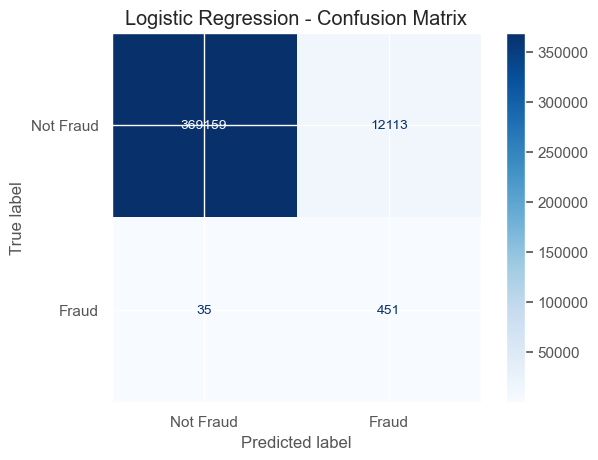

Accuracy:  0.96818
Precision: 0.03590
Recall:    0.92798
F1-score:  0.06912
ROC-AUC:   0.98792
PR-AUC:    0.62933
MCC:       0.17912

Model: Decision Tree


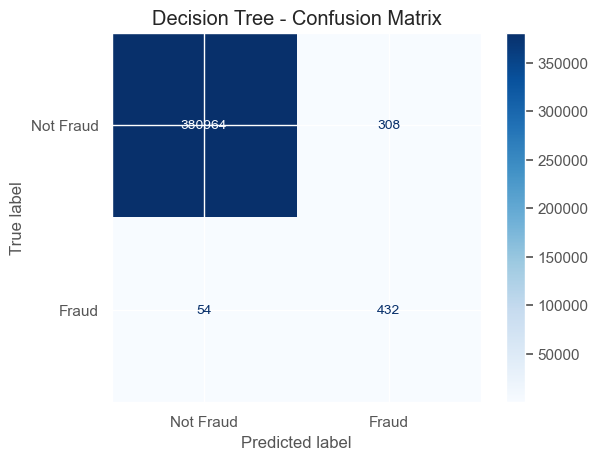

Accuracy:  0.99905
Precision: 0.58378
Recall:    0.88889
F1-score:  0.70473
ROC-AUC:   0.94404
PR-AUC:    0.73641
MCC:       0.71995

Model: Random Forest


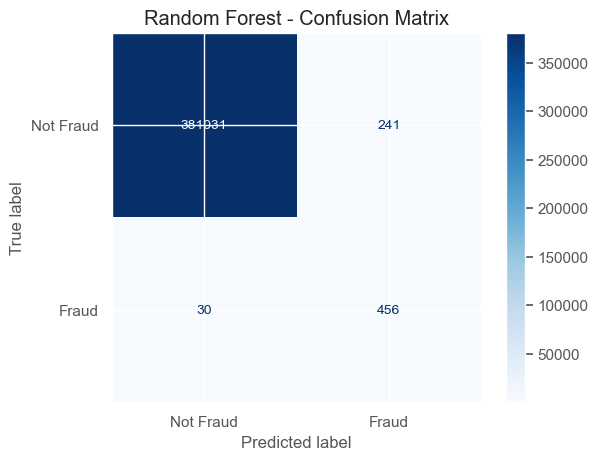

Accuracy:  0.99929
Precision: 0.65423
Recall:    0.93827
F1-score:  0.77092
ROC-AUC:   0.99673
PR-AUC:    0.93902
MCC:       0.78317

Model: Naive Bayes


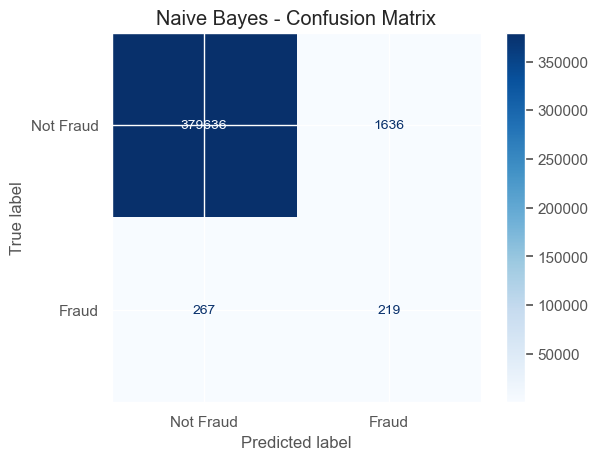

Accuracy:  0.99502
Precision: 0.11806
Recall:    0.45062
F1-score:  0.18710
ROC-AUC:   0.91533
PR-AUC:    0.23266
MCC:       0.22887

Model: XGBoost


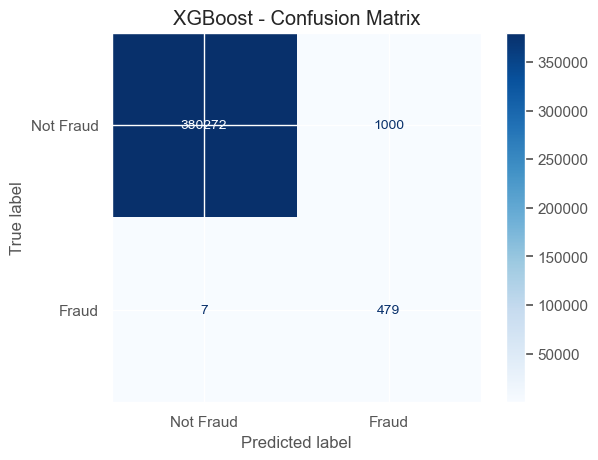

Accuracy:  0.99736
Precision: 0.32387
Recall:    0.98560
F1-score:  0.48753
ROC-AUC:   0.99633
PR-AUC:    0.95251
MCC:       0.56421

Model: LightGBM
[LightGBM] [Info] Number of positive: 889632, number of negative: 889632
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.111370 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2106
[LightGBM] [Info] Number of data points in the train set: 1779264, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


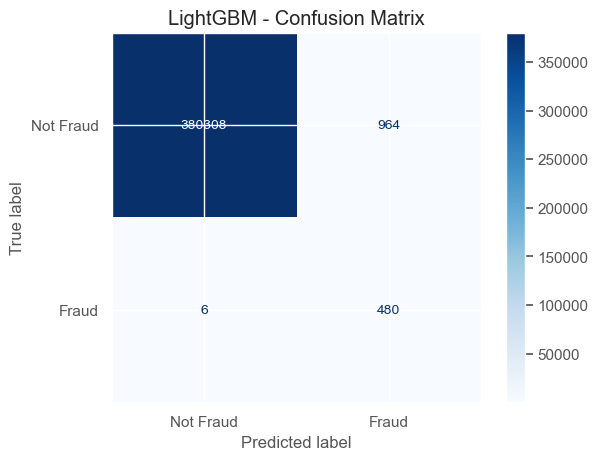

Accuracy:  0.99746
Precision: 0.33241
Recall:    0.98765
F1-score:  0.49741
ROC-AUC:   0.99658
PR-AUC:    0.95369
MCC:       0.57223

Model: CatBoost


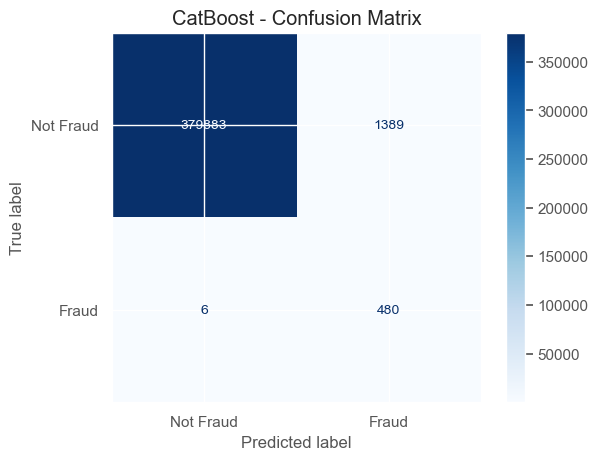

Accuracy:  0.99635
Precision: 0.25682
Recall:    0.98765
F1-score:  0.40764
ROC-AUC:   0.99598
PR-AUC:    0.94137
MCC:       0.50269


,Accuracy,Precision,Recall,F1-score,ROC-AUC,PR-AUC,MCC,Train_time_s
Model,,,,,,,,
Random Forest,0.999290,0.654232,0.938272,0.770921,0.996728,0.939020,0.783173,432.415730
Decision Tree,0.999052,0.583784,0.888889,0.704731,0.944041,0.736407,0.719945,68.981909
LightGBM,0.997459,0.332410,0.987654,0.497409,0.996577,0.953691,0.572233,21.029041
XGBoost,0.997362,0.323867,0.985597,0.487532,0.996328,0.952513,0.564212,40.648330
CatBoost,0.996346,0.256822,0.987654,0.407643,0.995984,0.941370,0.502693,73.215655
Naive Bayes,0.995015,0.118059,0.450617,0.187100,0.915330,0.232657,0.228865,1.164914
Logistic Regression,0.968179,0.035896,0.927984,0.069119,0.987920,0.629331,0.179125,18.846838


In [42]:

# -----------------------
# Run models on subsample
# -----------------------
for model, name in models:
    evaluate_model(model, name)

summary_df = pd.DataFrame(results).set_index("Model").sort_values(by="F1-score", ascending=False)
display(summary_df)

# Since fraud detection requires high recall + decent precision (catching as many frauds as possible, but not flagging everything as fraud), we look at F1-score + ROC-AUC:
10# 

LightGB 
 Weakst F10.49777), excellent recall0.9879 and Superfast3).# 

XGBoos
W weaker F10.4874,excellent recall (0.985)9) but very good ROC-AUC ach faer.


=== Final Training: XGBoost ===
              precision    recall  f1-score   support

           0    0.99998   0.99858   0.99928   1906322
           1    0.47251   0.98377   0.63840      2464

    accuracy                        0.99856   1908786
   macro avg    0.73625   0.99117   0.81884   1908786
weighted avg    0.99930   0.99856   0.99881   1908786

Training Time: 170.97 sec
Accuracy: 0.99856, Precision: 0.47251, Recall: 0.98377, F1: 0.63840, AUC: 0.99958


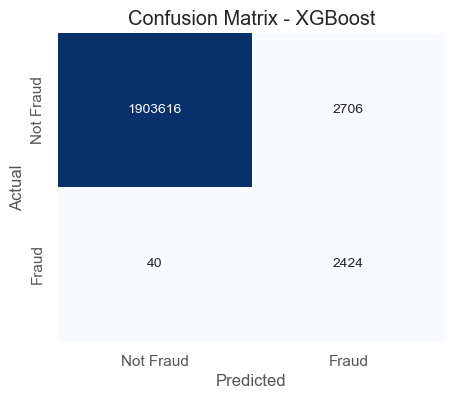


=== Final Training: LightGBM ===
[LightGBM] [Info] Number of positive: 4448085, number of negative: 4448085
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.237438 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2048
[LightGBM] [Info] Number of data points in the train set: 8896170, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
              precision    recall  f1-score   support

           0    0.99998   0.99782   0.99890   1906322
           1    0.36911   0.98823   0.53747      2464

    accuracy                        0.99780   1908786
   macro avg    0.68455   0.99302   0.76818   1908786
weighted avg    0.99917   0.99780   0.99830   1908786

Training Time: 84.80 sec
Accuracy: 0.99780, Precision: 0.36911, Recall: 0.98823, F1: 0.53747, AUC: 0.99936


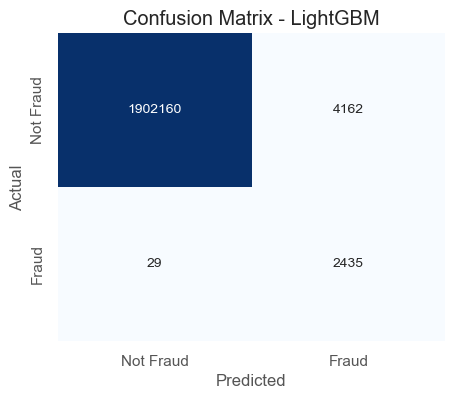


=== Final Model Comparison ===
      Model  Train Time (s)  Accuracy  Precision    Recall        F1   ROC-AUC
0   XGBoost      170.968304  0.998561   0.472515  0.983766  0.638399  0.999584
1  LightGBM       84.795834  0.997804   0.369107  0.988231  0.537468  0.999356


In [58]:

# -----------------------
# Final training on full dataset (only XGB + LGBM)
# -----------------------

df_full = preprocess(df)
X = df_full.drop('isFraud', axis=1)
y = df_full['isFraud']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

smote = SMOTE(random_state=42)
X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train)

final_models = [
    
    (XGBClassifier(
        use_label_encoder=False, eval_metric='logloss',
        n_estimators=300, max_depth=8, learning_rate=0.1,
        subsample=0.8, colsample_bytree=0.8, random_state=42, n_jobs=-1
    ), "XGBoost"),
    
    (LGBMClassifier(
        n_estimators=300, max_depth=-1, learning_rate=0.1,
        subsample=0.8, colsample_bytree=0.8, random_state=42, n_jobs=-1
    ), "LightGBM")
]

final_results = []


for model, name in final_models:
    print(f"\n=== Final Training: {name} ===")
    start = time.time()
    model.fit(X_train_sm, y_train_sm)
    train_time = time.time() - start
    
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None

    # Metrics
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_prob) if y_prob is not None else np.nan

    print(classification_report(y_test, y_pred, digits=5))
    print(f"Training Time: {train_time:.2f} sec")
    print(f"Accuracy: {acc:.5f}, Precision: {prec:.5f}, Recall: {rec:.5f}, F1: {f1:.5f}, AUC: {auc:.5f}")

    # Save results
    final_results.append({
        "Model": name,
        "Train Time (s)": train_time,
        "Accuracy": acc,
        "Precision": prec,
        "Recall": rec,
        "F1": f1,
        "ROC-AUC": auc
    })

    # Save model
    joblib.dump(model, f"{name.replace(' ','_')}_final.joblib")

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
                xticklabels=["Not Fraud", "Fraud"],
                yticklabels=["Not Fraud", "Fraud"])
    plt.title(f"Confusion Matrix - {name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()
    
results_df = pd.DataFrame(final_results)
print("\n=== Final Model Comparison ===")
print(results_df)
